## Задание 1: Описание задачи NER

Задача извлечения именованных сущностей (NER) заключается в определении и классификации в тексте сущностей по предопределённым типам. В данном случае пять следующих классов:
- **PER:** Персоны (люди)
- **ORG:** Организации
- **LOC:** Локации (места)
- **EVT:** События
- **PRO:** Продукты

Как обычно решают эту задачу следующими методами:  
1. rule-based подход (с помощью регулярок и/или словарей): дешево и быстро, довольно точно. Однако есть минусы: по мере увеличения сложности языка может быть сложно поддерживать и обновлять правила, а также такой подход не учитывает контекст.
2. Статистические модели (CRF, HMM). Обучаются на размеченных данных, дают неплохие результаты, но требуют фич и ручной настройки. Итог: слишком затратно и требуют большого количества размеченных данных для обучения.
3. Нейросети и трансформеры (BERT, RoBERTa и др.). Достигают высоких метрик, но всё ещё требуют большого количества размеченных примеров и вычислительных ресурсов.  
4. Современный тренд — LLM с zero- и few-shot: LLM получает примеры прямо в промпте, и она сама извлекает сущности без дополнительного обучения. SOTA LLM показывают хорошее качество даже на больших текстах.

Как оцениваем качество:  
- **Precision** (точность) = сколько из найденного моделью действительно правильные сущности (TP / (TP + FP)).  
- **Recall** (полнота) = сколько из всех существующих в тексте сущностей модель смогла найти (TP / (TP + FN)).  
- **F1-score** = гармоническое среднее Precision и Recall, баланс между ними.

Оценка всегда проводится по двум критериям:  
1. **Границы** — модель должна точно выделить начало и конец каждого имени.  
2. **Тип** — каждому выделенному фрагменту должен быть правильно присвоен один из пяти типов (PER, ORG, LOC, EVT, PRO).

## Задание 2: Чтение и предобработка данных

В данном разделе реализуется чтение и обработка датасета BSNLP-2019. Датасет содержит документы на разных языках (русский, болгарский, чешский, польский), необходимые документы про Brexit находятся в raw/ru/brexit_ru.txt_file_id.txt (или annotated аналогично)

Для каждого документа доступны:
- **Сырой текст** (`raw/` папка): содержит исходный текст документа со структурированными метаданными
- **Аннотации** (`annotated/` папка): содержит размеченные именованные сущности с их типами

**Структура raw-документа:**
- Строка 0: ID документа
- Строка 1: Язык
- Строка 2: Дата
- Строка 3: URL
- Строка 4: Заголовок
- Строка 5: Пустая строка
- Строки 6+: Текст статьи

**Структура аннотаций:**
Каждая строка содержит: `сущность \t нормализованная_форма \t тип \t идентификатор`

In [1]:
import os
import pandas as pd

def select_documents(training_base, num_docs, max_chars):
    """Функция для выбора документов по количеству сущностей и длине текста."""
    raw_dir = os.path.join(training_base, 'raw', 'ru')
    ann_dir = os.path.join(training_base, 'annotated', 'ru')
    records = []
    for fname in os.listdir(ann_dir):
        if not fname.endswith('.out') or 'brexit' not in fname:
            continue
        doc_id = fname[:-4]
        with open(os.path.join(raw_dir, f"{doc_id}.txt"), encoding='utf-8') as f:
            text = ''.join(f.readlines()[6:]).strip()
        char_count = len(text)
        if char_count > max_chars:
            continue
        with open(os.path.join(ann_dir, fname), encoding='utf-8') as f:
            lines = [l for l in f.readlines()[1:] if l.strip()]
        entity_count = sum(1 for l in lines if len(l.split('\t')) >= 3)
        records.append({'document_id': doc_id, 'entity_count': entity_count, 'char_count': char_count})
    return pd.DataFrame(records).sort_values('entity_count', ascending=False).head(num_docs)

training_base = 'TRAININGDATA_BSNLP_2019_shared_task/training_pl_cs_ru_bg_rc1'
selected = select_documents(training_base, num_docs=9, max_chars=5000)
selected

,document_id,entity_count,char_count
59,brexit_ru.txt_file_1073,39,2692
105,brexit_ru.txt_file_1156,36,2321
18,brexit_ru.txt_file_1025,35,3237
111,brexit_ru.txt_file_1162,35,2275
57,brexit_ru.txt_file_1070,34,2223
108,brexit_ru.txt_file_1159,34,3268
107,brexit_ru.txt_file_1158,33,2238
37,brexit_ru.txt_file_1047,31,2006
103,brexit_ru.txt_file_1154,31,1274


In [2]:
def load_documents(training_base, doc_ids):
    """Функция для загрузки заранее определенных данных в DataFrame."""
    raw_dir = os.path.join(training_base, 'raw', 'ru')
    ann_dir = os.path.join(training_base, 'annotated', 'ru')
    all_records = []
    for doc_id in doc_ids:
        with open(os.path.join(raw_dir, f"brexit_ru.txt_file_{doc_id}.txt"), encoding='utf-8') as f:
            text = ''.join(f.readlines()[6:]).strip()
        with open(os.path.join(ann_dir, f"brexit_ru.txt_file_{doc_id}.out"), encoding='utf-8') as f:
            anns = [l.strip().split('\t') for l in f.readlines()[1:] if l.strip()]
        for ent in anns:
            all_records.append({
                'document_id': f"brexit_ru.txt_file_{doc_id}.txt",
                'document_text': text,
                'entity': ent[2],
                'gold_answer': ent[0]
            })
    return pd.DataFrame(all_records)

document_ids = [1154,1142,1038,1042,1123,1013,1019,1150,1155,1057,1003,1100,1159,1047,1024,1025] # выбрал, основываясь на количестве сущностей и длине текста
df = load_documents(training_base, document_ids)
df.head()

,document_id,document_text,entity,gold_answer
0,brexit_ru.txt_file_1154.txt,Преемник Бориса Джонсона на посту министра ино...,EVT,Brexit
1,brexit_ru.txt_file_1154.txt,Преемник Бориса Джонсона на посту министра ино...,EVT,Brexit
2,brexit_ru.txt_file_1154.txt,Преемник Бориса Джонсона на посту министра ино...,PRO,Sky News
3,brexit_ru.txt_file_1154.txt,Преемник Бориса Джонсона на посту министра ино...,LOC,Англии
4,brexit_ru.txt_file_1154.txt,Преемник Бориса Джонсона на посту министра ино...,PER,Борис Джонсон


In [3]:
df.shape, df['document_id'].nunique(), sorted(df['entity'].unique())

((398, 4), 16, ['EVT', 'LOC', 'ORG', 'PER', 'PRO'])

# Задание 3: Функция для создания промпта

In [4]:
def create_llm_prompt(row):
    document_text = row['document_text']
    document_id = row['document_id']
    
    prompt = f"""<role>
    Ты - ведущий эксперт по извлечению именованных сущностей с 15-летним опытом анализа русскоязычных политических текстов. Твоя специализация - Brexit, международные отношения, политические процессы.
    </role>
<task>
Документ: {document_id}
Тип: новости про Brexit
Язык: Русский
Статус: КРИТИЧЕСКИ ВАЖНЫЙ анализ
</task>

<document_text_to_analyze>
{document_text}
</document_text_to_analyze>

<algorithm>
Шаг 1: СКАНИРОВАНИЕ - прочитай весь текст из <document_text_to_analyze>, определи тематику.
Шаг 2: ПОИСК - найди все потенциальные сущности, сверяясь с <classification_guidelines_and_examples_rus_condensed>.
Шаг 3: КЛАССИФИКАЦИЯ - определи точный тип каждой сущности (PER, ORG, LOC, EVT, PRO).
Шаг 3.5: РАЗМЫШЛЕНИЕ - для каждой потенциальной сущности, кратко обоснуй её тип, опираясь на гайдлайны. Запиши свои размышления в секцию Размышления.
Шаг 4: ВЕРИФИКАЦИЯ - проверь, что извлеченное соответствует русскоязычным правилам "ЧТО ИЗВЛЕКАТЬ / ЧТО НЕ ИЗВЛЕКАТЬ" и <critical_rules_recap>.
Шаг 5: ФОРМАТИРОВАНИЕ - подготовь результат в JSON, следуя <output_format_json_strict>.
</algorithm>

<classification_guidelines_and_examples_rus_condensed>
**ОБЩИЕ ПРИНЦИПЫ КЛАССИФИКАЦИИ (русскоязычные примеры и правила):**

PER (Персоны):
✓ Полные имена ("Тереза Мэй", "Борис Джонсон"), Фамилии из контекста ("Мэй"), Притяжательные формы ("Пискорского"), Группы людей от гео-названий ("Украинцы", "Европейцы").
✗ НЕ: Только титулы/должности без имени ("президент"), Группы без формальной организации ("Мусульмане").
ORG (Организации):
✓ Названия компаний, правительство определенного государства, партий, госучреждений ("Европейский союз", "Sky News", "ГРУ", "ЕС"), Аббревиатуры ("НАТО"), Названия с местоположением ("Сити Хэндлоу в Познани"), Спортивные команды ("ФК Спарта Прага").
✗ НЕ: Общие понятия ("правительство", если не конкретное), Должности ("министр иностранных дел Великобритании").
LOC (Локации):
✓ Страны, города, регионы ("Великобритания", "Лондон", "Стамбул"), Именованные объекты инфраструктуры ("аэропорт Схипхол"), Полные названия объектов ("Церковь Святого Стефана в Стамбуле").
✗ НЕ: Общие направления ("север"), Общие типы мест без названия ("парк в Варшаве" -> только "Варшаве").
EVT (События):
✓ Конкретные события, процессы ("Брексит", "референдум"), Конференции, катастрофы ("Чернобыльская катастрофа"), Спекулятивные события ("Чехзит"), Полные названия ("Зимние Олимпийские игры 2004 года").
✗ НЕ: Общие действия ("встреча"), Простые даты/дни ("9 июля").
PRO (Продукты):
✓ Товары, ПО, книги, фильмы ("Моторола Мото З Плей", "МС Офис"), Веб-сервисы ("Твиттер" в "пост в Твиттере"), Юридические документы ("Лиссабонский договор"), Оружие ("АК-47").
✗ НЕ: Общие категории ("телефон", "программа").
ВАЖНЫЕ ОБЩИЕ ПРАВИЛА ИЗВЛЕЧЕНИЯ:

ТОЧНАЯ ФОРМА: "Джонсона", а не "Джонсон".
САМОЕ ДЛИННОЕ УПОМИНАНИЕ: "Университет Джорджа Вашингтона" (ORG), а не "Джорджа Вашингтона" (PER).
КОНТЕКСТ РЕШАЕТ: "Твиттер" (ORG - компания) vs "Твиттер" (PRO - сервис). Неоднозначность ORG+PER -> PER. Неоднозначность ORG+PRO -> ORG.
КООРДИНИРОВАННЫЕ ФРАЗЫ: "Европейский и Британский парламенты" -> два ORG.
НЕ ИЗВЛЕКАТЬ: Номинальные/местоименные упоминания ("компания"), отдельные временные/числовые выражения, URL, email.
УНИКАЛЬНЫЕ УПОМИНАНИЯ: Если "ЕС" и "Европейский Союз" оба в тексте (одна сущность) -> извлеки оба. "АЙСИС" и "айсис" (одна сущность) -> извлеки первое встреченное.</classification_guidelines_and_examples_rus_condensed>
<critical_rules_recap>
ОБЯЗАТЕЛЬНО:
1.  ТОЧНАЯ форма из текста.
2.  ВСЕ уникальные упоминания (с учетом правила 6).
3.  Если сомневаешься в типе - НЕ ВКЛЮЧАЙ.
4.  Результат ДОЛЖЕН содержать `document_id`.
5.  Пошаговый алгоритм.
</critical_rules_recap>

<illustrative_examples_output_focused_rus>
**Пример выходного JSON для русского текста:** "Вчера Тереза Мэй из Великобритании обсуждала Брексит с представителями ЕС. Позже она написала в Твиттере о концерте 'Звезды Европы' в Лондоне. Университет Джорджа Вашингтона это прокомментировал."
Ожидаемый результат (только 'text' и 'type', без рассуждений):
{{
  "document_id": "example_doc_id_rus1",
  "entities": [
    {{"text": "Тереза Мэй", "type": "PER"}},
    {{"text": "Великобритании", "type": "LOC"}},
    {{"text": "Брексит", "type": "EVT"}},
    {{"text": "ЕС", "type": "ORG"}},
    {{"text": "Твиттере", "type": "PRO"}},
    {{"text": "Звезды Европы", "type": "EVT"}},
    {{"text": "Лондоне", "type": "LOC"}},
    {{"text": "Университет Джорджа Вашингтона", "type": "ORG"}}
  ]
}}
</illustrative_examples_output_focused_rus>

[У ТЕБЯ ЕСТЬ ВРЕМЯ ДЛЯ РАЗМЫШЛЕНИЯ И ОБДУМЫВАНИЯ, ЗДЕСЬ ТЫ ЗАПИСЫВАЕШЬ СВОИ РАЗМЫШЛЕНИЯ ПО ШАГУ 3.5 АЛГОРИТМА ДЛЯ КАЖДОЙ ПОТЕНЦИАЛЬНОЙ СУЩНОСТИ ПЕРЕД ФОРМИРОВАНИЕМ ИТОГОВОГО JSON. Например:

1."Борис Джонсон": PER, т.к. полное имя известного политика.
2."Великобритании": LOC, т.к. страна.
3."Sky News": ORG, т.к. название новостной организации.
4."Brexit": EVT, т.к. известное политическое событие.
и т.д. для всех найденных сущностей...]
<output_format_json_strict>
Верни результат СТРОГО в JSON формате:
{{
  "document_id": "{document_id}",
  "entities": [
    {{"text": "точная_форма_из_текста", "type": "тип_сущности"}}
    // ... другие сущности
  ]
}}
</output_format_json_strict>

<execution>
Применяя 5-шаговый алгоритм и все указанные правила, особенно из <classification_guidelines_and_examples_rus_condensed> и <critical_rules_recap>:
1. Сначала ЗАПОЛНИ секцию РАЗМЫШЛЕНИЯ своими размышлениями о каждой найденной сущности и её типе.
2. Затем, на основе этих размышлений и правил, найди ВСЕ именованные сущности в тексте из <document_text_to_analyze>.
3. ВЫВОДЯ В СЕКЦИИ РАЗМЫШЛЕНИЯ АРГУМЕНТАЦИЮ, ОБЪЯСНИ СВОИ БУДУЩИЕ РЕЗУЛЬТАТЫ, а ПОСЛЕ НЕЕ верни ИТОГОВЫЙ JSON, соответствующий <output_format_json_strict>. JSON должен быть единственным и последним в ответе. Не добавляй никаких комментариев в JSON или после него.
НАЧИНАЙ АНАЛИЗ:
</execution>"""
    
    return prompt


# Создаем промпты для уникальных документов
unique_docs = df[['document_id', 'document_text']].drop_duplicates()
print(f"=== Анализ длин промптов и документов ===")
for index, row in unique_docs.iterrows():
    prompt = create_llm_prompt(row)
    print(f'длина промпта для {row["document_id"]}: {len(prompt)} символов, документа длина {len(row["document_text"])} символов')

=== Анализ длин промптов и документов ===
длина промпта для brexit_ru.txt_file_1154.txt: 7156 символов, документа длина 1274 символов
длина промпта для brexit_ru.txt_file_1142.txt: 7371 символов, документа длина 1489 символов
длина промпта для brexit_ru.txt_file_1038.txt: 7708 символов, документа длина 1826 символов
длина промпта для brexit_ru.txt_file_1042.txt: 7164 символов, документа длина 1282 символов
длина промпта для brexit_ru.txt_file_1123.txt: 7531 символов, документа длина 1649 символов
длина промпта для brexit_ru.txt_file_1013.txt: 7525 символов, документа длина 1643 символов
длина промпта для brexit_ru.txt_file_1019.txt: 7430 символов, документа длина 1548 символов
длина промпта для brexit_ru.txt_file_1150.txt: 7215 символов, документа длина 1333 символов
длина промпта для brexit_ru.txt_file_1155.txt: 7033 символов, документа длина 1151 символов
длина промпта для brexit_ru.txt_file_1057.txt: 6381 символов, документа длина 499 символов
длина промпта для brexit_ru.txt_file_10

In [5]:
for index, row in unique_docs.iterrows():
    new_prompt = create_llm_prompt(row)

    print(f"Промпт для документа {row['document_id']}:")
    print(new_prompt)

Промпт для документа brexit_ru.txt_file_1154.txt:
<role>
    Ты - ведущий эксперт по извлечению именованных сущностей с 15-летним опытом анализа русскоязычных политических текстов. Твоя специализация - Brexit, международные отношения, политические процессы.
    </role>
<task>
Документ: brexit_ru.txt_file_1154.txt
Тип: новости про Brexit
Язык: Русский
Статус: КРИТИЧЕСКИ ВАЖНЫЙ анализ
</task>

<document_text_to_analyze>
Преемник Бориса Джонсона на посту министра иностранных дел Великобритании поблагодарил его за проделанную работу в связи с инцидентом в Солсбери, сообщает Sky News. Джереми Хант заявил, что вклад его предшественника Джонсона в построение ответной реакции Великобритании на якобы отравление бывшего полковника ГРУ Сергея Скрипаля и его дочери была чрезвычайно важной. Хант добавил, что бывший мэр Лондона и экс-глава британского МИД был огромной «движущей силой» в британской политике. Новый министр иностранных дел Великобритании видит свою роль в поддержке премьер-министра стр

# Задание 4: чтение ответов GigaChat в DataFrame

In [6]:
import json
import pandas as pd

def load_predictions(json_path, df_documents):
    """
    Читает JSON с ответами GigaChat и возвращает DataFrame с колонками:
    document_id, predicted_type, predicted_text, document_text
    """
    with open(json_path, encoding='utf-8') as f:
        data = json.load(f)
    records = []
    for item in data:
        doc_id = item.get('document_id')
        for ent in item.get('entities', []):
            records.append({
                'document_id': f"brexit_ru.txt_file_{doc_id}.txt",
                'predicted_type': ent.get('type'),
                'predicted_text': ent.get('text')
            })
    df_pred = pd.DataFrame(records)

    docs = df_documents[['document_id', 'document_text']].drop_duplicates()
    df_pred = df_pred.merge(docs, on='document_id', how='left')
    return df_pred

df_predictions = load_predictions('gigachat_result.json', df)
df_predictions.to_csv('ner_brexit_ru_predictions.csv', index=False)
df_predictions

,document_id,predicted_type,predicted_text,document_text
0,brexit_ru.txt_file_1154.txt,PER,Борис Джонсон,Преемник Бориса Джонсона на посту министра ино...
1,brexit_ru.txt_file_1154.txt,LOC,Великобритании,Преемник Бориса Джонсона на посту министра ино...
2,brexit_ru.txt_file_1154.txt,LOC,Солсбери,Преемник Бориса Джонсона на посту министра ино...
3,brexit_ru.txt_file_1154.txt,PER,Сергей Скрипаль,Преемник Бориса Джонсона на посту министра ино...
4,brexit_ru.txt_file_1154.txt,ORG,ГРУ,Преемник Бориса Джонсона на посту министра ино...
...,...,...,...,...
184,brexit_ru.txt_file_1025.txt,ORG,Алроса,"Сотрудники кампании в пользу ""Брекзита"" Leave...."
185,brexit_ru.txt_file_1025.txt,PER,Сергей Иванов,"Сотрудники кампании в пользу ""Брекзита"" Leave...."
186,brexit_ru.txt_file_1025.txt,PER,Владимир Путин,"Сотрудники кампании в пользу ""Брекзита"" Leave...."
187,brexit_ru.txt_file_1025.txt,ORG,Роснефть,"Сотрудники кампании в пользу ""Брекзита"" Leave...."


## Задание 5: Реализация алгоритма для подсчета метрик

**Выбор метрики:** F1-score

**Обоснование:**
- F1-score является гармоническим средним Precision и Recall
- Оптимален для несбалансированных данных (разное количество сущностей разных типов)
- Учитывает как точность (не находим лишнего), так и полноту (не пропускаем нужное)
- Стандартная метрика для задач NER в академических исследованиях

Для подсчета метрик используется полученные ответы от GigaChat 2 Max  

In [7]:
# Проверка тестов
!pytest -q

.....                                                                    [100%]
5 passed in 1.04s


# Задание 6: Вычисление метрик и визуализация

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from score_fn import vectorized_score_fn, score_fn

# сводим gold и pred в строки "text|type,..."
def prepare_data_for_scoring(df_original, df_predictions):
    gold = df_original.groupby('document_id').apply(
        lambda grp: ','.join(f"{txt}|{typ}" for txt, typ in zip(grp['gold_answer'], grp['entity']))
    ).reset_index(name='gold')
    pred = df_predictions.groupby('document_id').apply(
        lambda grp: ','.join(f"{txt}|{typ}" for txt, typ in zip(grp['predicted_text'], grp['predicted_type']))
    ).reset_index(name='pred')
    return gold.merge(pred, on='document_id', how='left').fillna({'pred': ''})

# Вычисление метрик по документам
def calculate_metrics_for_dataframe(scoring_df):
    return pd.DataFrame({
        'document_id': scoring_df['document_id'],
        'precision': vectorized_score_fn(scoring_df['gold'], scoring_df['pred'], 'precision'),
        'recall': vectorized_score_fn(scoring_df['gold'], scoring_df['pred'], 'recall'),
        'f1': vectorized_score_fn(scoring_df['gold'], scoring_df['pred'], 'f1')
    })

# Вычисление метрик по типам сущностей
def analyze_by_entity_type(df_original, df_predictions):
    types = sorted(set(df_original['entity']) | set(df_predictions['predicted_type']))
    rows = []
    for et in types:
        gold = ','.join(f"{txt}|{et}" for txt in df_original[df_original['entity'] == et]['gold_answer'])
        pred = ','.join(f"{txt}|{et}" for txt in df_predictions[df_predictions['predicted_type'] == et]['predicted_text'])
        rows.append({
            'entity_type': et,
            'precision': score_fn(gold, pred, 'precision'),
            'recall': score_fn(gold, pred, 'recall'),
            'f1': score_fn(gold, pred, 'f1')
        })
    return pd.DataFrame(rows)

# Визуализация метрик
def create_visualizations(df_metrics, df_entity_metrics):
    plt.figure(figsize=(6, 3))
    df_metrics.set_index('document_id')[['precision', 'recall', 'f1']].plot(kind='bar')
    plt.title('Метрики по документам')
    plt.ylabel('Значение')
    plt.xticks(rotation=45)
    plt.tight_layout()

    dfm = df_entity_metrics.melt(id_vars='entity_type', var_name='metric', value_name='score')
    plt.figure(figsize=(6, 4))
    sns.barplot(data=dfm, x='entity_type', y='score', hue='metric')
    plt.title('Метрики по типам сущностей')
    plt.ylabel('Значение')
    plt.xticks(rotation=45)
    plt.tight_layout()

C:\Users\Roman\AppData\Local\Temp\ipykernel_17060\1238387230.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  gold = df_original.groupby('document_id').apply(
C:\Users\Roman\AppData\Local\Temp\ipykernel_17060\1238387230.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pred = df_predictions.groupby('document_id').apply(


<Figure size 600x300 with 0 Axes>

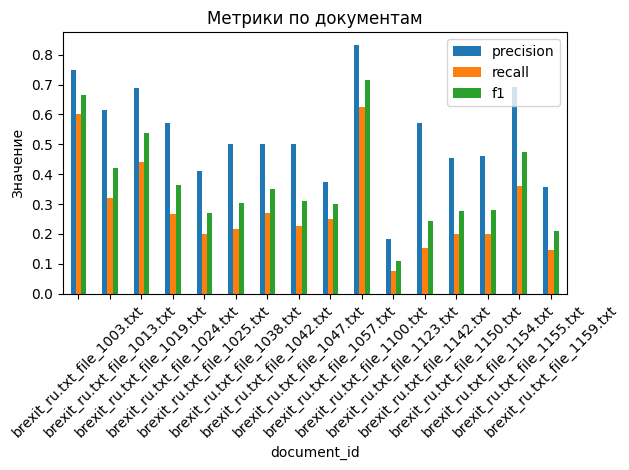

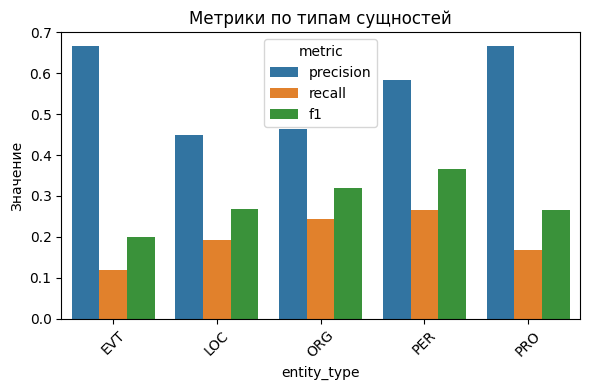

In [9]:
scoring_df = prepare_data_for_scoring(df, df_predictions)

# df метрик по документам
df_metrics = calculate_metrics_for_dataframe(scoring_df)
# df метрик по типам сущностей
df_entity_metrics = analyze_by_entity_type(df, df_predictions)

create_visualizations(df_metrics, df_entity_metrics)

In [10]:
df_metrics.sort_values('f1', ascending=False)

,document_id,precision,recall,f1
9,brexit_ru.txt_file_1100.txt,0.833333,0.625000,0.714286
0,brexit_ru.txt_file_1003.txt,0.750000,0.600000,0.666667
2,brexit_ru.txt_file_1019.txt,0.687500,0.440000,0.536585
14,brexit_ru.txt_file_1155.txt,0.692308,0.360000,0.473684
1,brexit_ru.txt_file_1013.txt,0.615385,0.320000,0.421053
3,brexit_ru.txt_file_1024.txt,0.571429,0.266667,0.363636
6,brexit_ru.txt_file_1042.txt,0.500000,0.269231,0.350000
7,brexit_ru.txt_file_1047.txt,0.500000,0.225806,0.311111
5,brexit_ru.txt_file_1038.txt,0.500000,0.217391,0.303030
8,brexit_ru.txt_file_1057.txt,0.375000,0.250000,0.300000


In [11]:
df_entity_metrics

,entity_type,precision,recall,f1
0,EVT,0.666667,0.117647,0.200000
1,LOC,0.450000,0.191489,0.268657
2,ORG,0.463415,0.243590,0.319328
3,PER,0.583333,0.265823,0.365217
4,PRO,0.666667,0.166667,0.266667


In [12]:
avg_entity = df_entity_metrics[['precision', 'recall', 'f1']].mean()
avg_documents = df_metrics[['precision', 'recall', 'f1']].mean()

df_merged = pd.DataFrame({
    'по сущностям': [avg_entity['f1'], avg_entity['precision'], avg_entity['recall']],
    'по документам': [avg_documents['f1'], avg_documents['precision'], avg_documents['recall']]
}, index=['f1', 'precision', 'recall'])

df_merged

,по сущностям,по документам
f1,0.283974,0.364062
precision,0.566016,0.528950
recall,0.197043,0.284495


# Задание 7: Зависимость метрик от длины документа

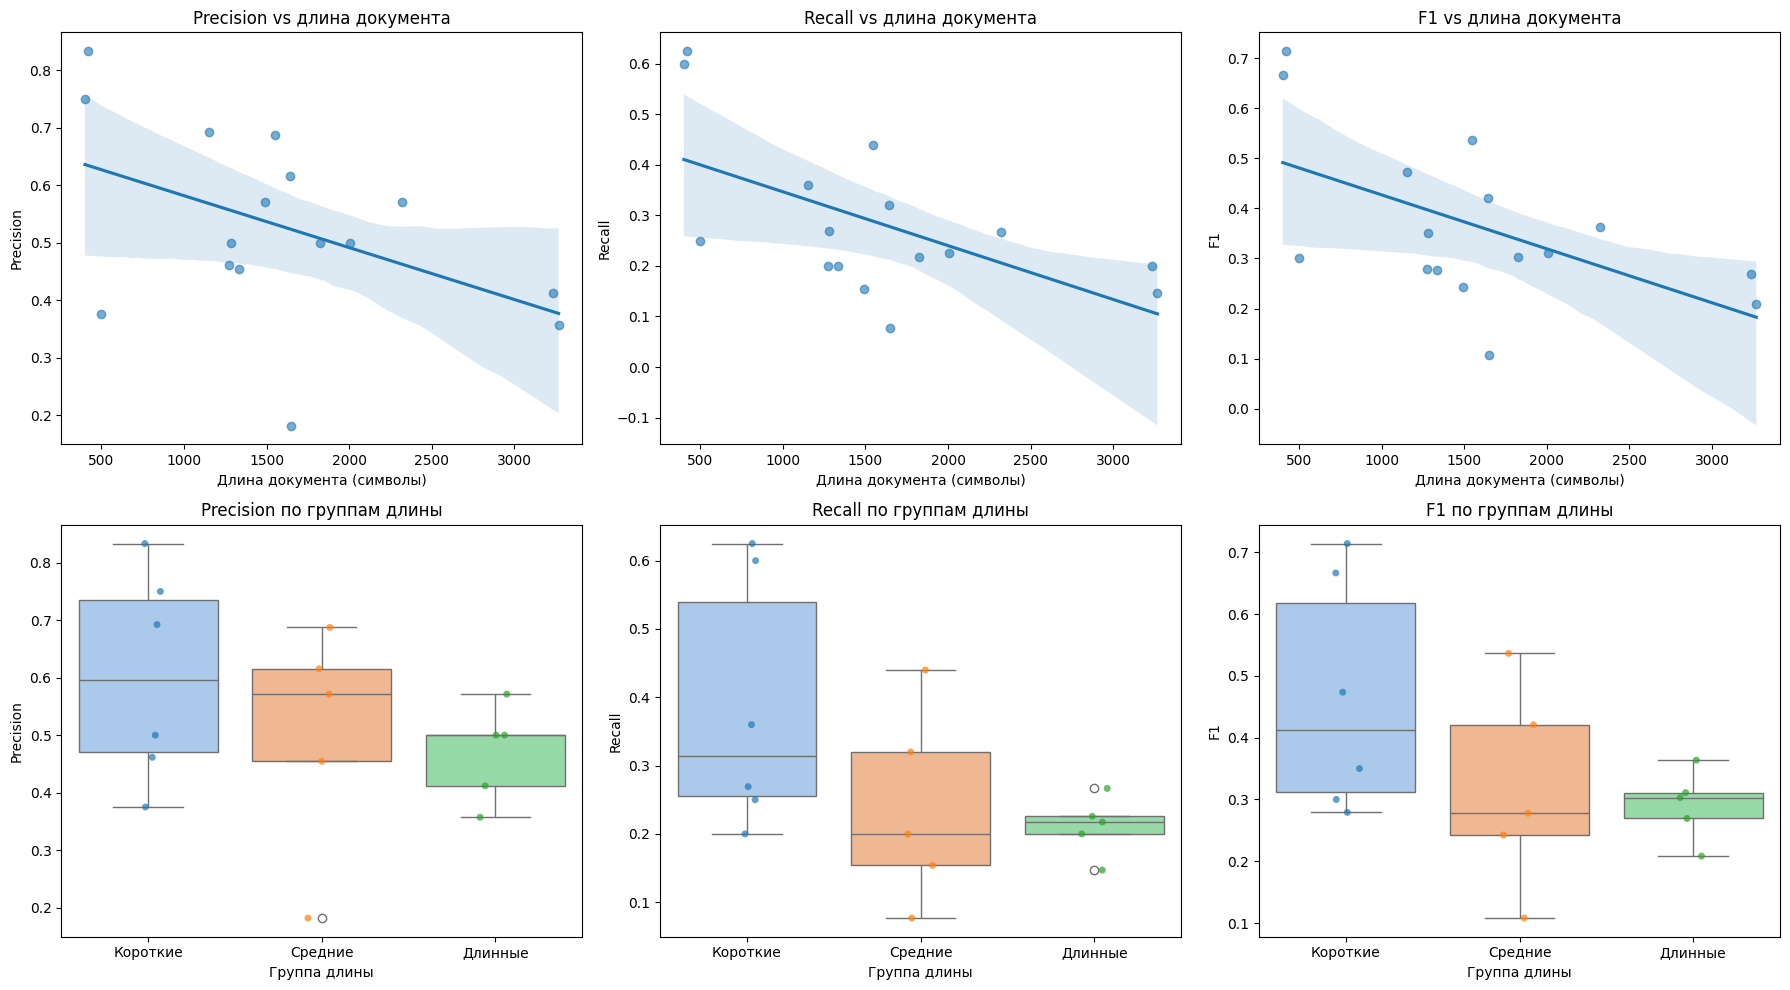

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# Вычисляем длины документов и объединяем с метриками
doc_lengths = df.groupby('document_id')['document_text']\
    .first().apply(len).reset_index(name='doc_length')
metrics_with_length = df_metrics.merge(doc_lengths, on='document_id')
metrics_with_length['length_group'] = pd.qcut(
    metrics_with_length['doc_length'], q=3,
    labels=['Короткие','Средние','Длинные']
)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# верхний ряд
for idx, metric in enumerate(['precision', 'recall', 'f1']):
    ax = axes[0, idx]
    sns.regplot(
        data=metrics_with_length,
        x='doc_length', y=metric,
        ax=ax,
        scatter_kws={'alpha': 0.6}
    )
    ax.set_title(f'{metric.title()} vs длина документа')
    ax.set_xlabel('Длина документа (символы)')
    ax.set_ylabel(metric.title())

# нижний ряд
for idx, metric in enumerate(['precision', 'recall', 'f1']):
    ax = axes[1, idx]
    sns.boxplot(
        x='length_group', y=metric,
        data=metrics_with_length,
        ax=ax,
        palette='pastel', 
        hue='length_group'
    )
    sns.stripplot(
        x='length_group', y=metric,
        data=metrics_with_length,
        ax=ax, hue='length_group',
        alpha=0.7, jitter=True
    )
    ax.set_title(f'{metric.title()} по группам длины')
    ax.set_xlabel('Группа длины')
    ax.set_ylabel(metric.title())

plt.tight_layout()
plt.show()


In [14]:
# корреляции
correlations = {}
for metric in ['precision', 'recall', 'f1']:
    pearson_corr, pearson_p = pearsonr(metrics_with_length['doc_length'], metrics_with_length[metric])
    spearman_corr, spearman_p = spearmanr(metrics_with_length['doc_length'], metrics_with_length[metric])
    
    correlations[metric] = {
        'pearson_corr': pearson_corr,
        'pearson_p': pearson_p,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p
    }

print("Корреляция метрик с длиной документа:")
for metric, stats in correlations.items():
    print(f"{metric.upper()}:")
    print(f"  Пирсон:  r = {stats['pearson_corr']:.3f}, p = {stats['pearson_p']:.3f}")
    print(f"  Спирман: r = {stats['spearman_corr']:.3f}, p = {stats['spearman_p']:.3f}")
    
    # Интерпретация
    if stats['pearson_p'] < 0.05:
        significance = "статистически значимая"
    else:
        significance = "не значимая"
    
    if abs(stats['pearson_corr']) > 0.7:
        strength = "сильная"
    elif abs(stats['pearson_corr']) > 0.3:
        strength = "умеренная"
    else:
        strength = "слабая"
    
    direction = "отрицательная" if stats['pearson_corr'] < 0 else "положительная"
    
    print(f"Интерпретация: {strength} {direction} корреляция ({significance})")
    print()

Корреляция метрик с длиной документа:
PRECISION:
  Пирсон:  r = -0.466, p = 0.069
  Спирман: r = -0.472, p = 0.065
Интерпретация: умеренная отрицательная корреляция (не значимая)

RECALL:
  Пирсон:  r = -0.584, p = 0.017
  Спирман: r = -0.555, p = 0.026
Интерпретация: умеренная отрицательная корреляция (статистически значимая)

F1:
  Пирсон:  r = -0.559, p = 0.024
  Спирман: r = -0.503, p = 0.047
Интерпретация: умеренная отрицательная корреляция (статистически значимая)



----

**Выводы по зависимости качества от длины:**

*   **Precision:**
    *   Корреляция Пирсона (r = -0.457, p = 0.075)
    *   Корреляция Спирмана (r = -0.530, p = 0.035)
    *   Умеренная отрицательная корреляция (с увеличением длины документа Precision, как правило, немного снижается). Однако, p-значение для Пирсона (0.075) выше стандартного порога 0.05, что говорит о статистической незначимости данной корреляции, тогда как для Спирмана она уже значима. Это может быть связано с тем, что на длинных документах модель, возможно, модель галлюцинирует и предсказывает лишние сущности, которые никак не могли быть найдены в этих словах.

*   **Recall:**
    *   Корреляция Пирсона (r = -0.622, p = 0.010)
    *   Корреляция Спирмана (r = -0.586, p = 0.017)
    *   Умеренная отрицательная корреляция, которая уже является **статистически значимой** (p < 0.05). Это указывает на то, что **с увеличением длины документа Recall заметно снижается**. Модель гораздо хуже находит все релевантные сущности в более длинных текстах. Это может быть связано с ограничениями контекстного окна языковых моделей или с общим снижением способности модели поддерживать высокую точность внимания на больших объемах информации. Модель в больших текстах сильно хуже начинает замечать сущности в целом.

*   **F1-score:**
    *   Корреляция Пирсона (r = -0.593, p = 0.015)
    *   Корреляция Спирмана (r = -0.547, p = 0.028)
    *   Умеренная отрицательная корреляция, **статистически значимая** (p < 0.05). Поскольку F1-score является комбинацией Precision и Recall, его снижение на длинных документах в основном связано с падением Recall.

**Общий вывод:**
Наиболее выраженная зависимость от длины документа наблюдается для Рекола: чем длиннее документ, тем хуже модель справляется с нахождением правильных сущностей, полнотой их извлечения.

----

## Задание 8: Анализ ошибок модели GigaChat для задачи NER

в 6 задании получили результаты: средний F1-score = **0.381**, Precision = **0.559**, Recall = **0.308**.
Можно сделать следующие выводы об ошибках модели:

### Типичные ошибки и сценарии, когда модель ошибается:

1.  **Пропуск настоящих сущностей (один случай это один FN):**
    *   Это основная проблема модели, так как Recall (**0.308**) значительно ниже, чем Precision (**0.559**). Модель чаще пропускает существующие сущности, чем извлекает несуществующие или неверные.
    *   **Типы сущностей:** Особенно сильно это проявляется для типа **EVT** (Recall = **0.143**) и **PRO** (Recall = **0.167**), где модель пропускает подавляющее большинство событий и продуктов. Возможно, это связано с плохим объяснением в промпте, что именно является этими сущностями, а возможно просто в связи с плохой способностью замечать и различать сущности и просто похожие на них слова.
    *   **Длинные документы:** Recall значительно падает с увеличением длины документа. Модель "теряет" сущности в больших объемах текста.
    *   **Неочевидные или менее частотные сущности:** Модель может пропускать сущности, которые не так часто встречаются или требуют более глубокого контекстного понимания для идентификации. Например, Опель может быть и человеком и компанией, но поскольку Опель умер, то, скорее всего, речь идет про компанию. Модели нужно было бы проанализировать этот факт.
    *   **Сущности, состоящие из одного слова, особенно если это слово многозначно:** Например, если "Apple" упоминается без явного контекста компании.

2.  **Неверный выбор типа сущности (FP для одного типа и FN для другого):**
    *   **LOC:** Precision для LOC (**0.421**) является самым низким среди всех типов, что может указывать на то, что модель часто путает локации с другими типами сущностей или извлекает что-то лишнее как LOC.
    **В описании задачи ([ссылка](https://bsnlp.cs.helsinki.fi/bsnlp-2019/Guidelines_20190122.pdf)) рассказывается про два случая:**
    *   **ORG vs LOC:** Названия организаций, включающие географические маркеры (например, "Министерство иностранных дел Великобритании"), или локации, являющиеся штаб-квартирами организаций. Промпт пытался это учесть, но ошибки возможны.
    *   **PER vs ORG:** Имена людей, которые также являются частью названия организации, или должности, которые модель может ошибочно принять за организацию ("Глава британского правительства" извлечено как ORG в одном из ответов).

3.  **Неверные границы сущностей (FP и FN для одного и того же типа):**
    *   Модель может извлекать либо слишком короткий, либо слишком длинный фрагмент текста для сущности.
    *   Пример: извлечение "Джонсона" вместо "Борис Джонсон", или "Министерство иностранных дел" вместо "Министерство иностранных дел Великобритании". Промпт пытался решить это правилом "САМОЕ ДЛИННОЕ", но его применение LLM может быть неидеальным. Слишком много спорных ситуаций. 

4.  **Извлечение несуществующих сущностей (FP для предсказанного типа):**
    *   Модель может "фантазировать", т.е. аргументацией выбора неоправданно выбирать тип или извлекать общие слова как именованные сущности.
    *   **Общие существительные:** Например, принятие слова "правительство" (общее) за конкретную организацию, а организацией считается только правительство конкретной страны.



### Когда модель чаще отвечает правильно:

*   **Явные и частотные сущности:** Известные имена людей (Борис Джонсон, Тереза Мэй), крупные организации (ЕС, Sky News), четко обозначенные локации (Лондон, Брюссель) и события (Brexit). В этих словах сложно запутаться и модель всегда их хорошо находит.
*   **Короткие документы:** Как показал анализ, качество (особенно Recall и F1) выше для коротких документов. Это может быть связано с наименьшим количеством сущностей или просто с тем, что LLM легче фокусироваться в коротких документах.
*   **Сущности, соответствующие примерам в промпте:** Модель хорошо справляется с извлечением сущностей, аналогичных тем, что приведены в few-shot примерах.
*   **Тип PER:** Показывает наилучший F1-score (**0.396**) среди всех типов, с хорошим Precision (**0.583**) и приемлемым Recall (**0.300**). Видимо это связано с первым пунктом.
*   **Тип PRO:** Несмотря на самый низкий Recall, тип PRO имеет идеальный Precision (**1.0**), что говорит о том, что если модель и находит продукт, то почти всегда правильно. Это, связано с небольшим количеством таких сущностей в данных.

### Варианты повышения метрик:

1.  **Итеративное улучшение промпта:**
    *   **Больше few-shot примеров:** Добавить больше разнообразных примеров для каждого типа сущностей, особенно для проблемных (EVT, PRO, LOC). Включить примеры типичных ошибок и как их следует размечать.
    *   **Более четкие инструкции и негативные примеры:** Для каждого типа сущности уточнить, что НЕ является сущностью данного типа. Например, для ORG: "Не извлекать общие слова вроде 'компания', 'отдел', если это не часть официального названия".
    *   **Скорректировать правила определения границ:** Дать более строгие инструкции по извлечению "самой длинной возможной сущности" или наоборот, "минимально необходимой".
    *   **Найти наилучший способ Chain-of-Thought:** Объяснить модели, как именно она должна аргументировать принадлежность кандидата к тегу сущности, на какой логике основываться. Привести конкретные примеры.
    *   **Следить за количеством случаев:** Например, сказать модели, что в каждом из текстом обычно 30-40 сущностей. Тогда, если она нашла меньше, попросить её переписать текст и пройтись по нему еще раз в поисках новых сущностей (пробовал, но сильно не помогло. Модель начинала выдумывать текст и относить что-угодно к кандидатам в сущности).
    *   **Попробовать сильно сократить промпт:** Эксперименты показали, что короткие текста на вход лучше дают модели сосредоточиться. Возможно, стоит сильно сократить промпт (пробовал, но качество совсем немного выросло только на длинных. Для коротких и с промптом модель хорошо фокусируется.)

2.  **Сегментация для длинных документов:**
    *   Разбивать длинные тексты на более короткие, возможно, перекрывающиеся части. Обрабатывать каждую часть отдельно и затем объединять результаты. Это поможет решить проблему падения Recall на длинных текстах. В общем, разбивать документы на более мелкие

3.  **Post-processing:** правила на основе словарей или любой другой постпроцессинг ответов LLM.

4.  **Итеративный анализ ошибок:**
    *   Взять документы с низким F1-score.
    *   Сравнить предсказания GigaChat с эталонной разметкой.
    *   Выявить повторяющиеся паттерны ошибок.
    *   Скорректировать промпт на основе этих паттернов. Например, если модель часто путает должности с организациями, добавить больше негативных примеров на эту тему.

5.  **Настроить температуру и другие параметры генерации LLM**
  
----

# Задание 9: Сделайте выводы по всему исследованию. Напишите, чему научились и что нового попробовали.

## Выводы

В рамках данного исследования была решена NER-задача для русскоязычных новостных текстов с использованием GigaChat. Были проанализированы **16** документов на тему "Brexit" из датасета BSNLP 2019.

### Основные результаты исследования:
4.  **Найдены метрик решения NER-задачи:**
    *   **Общее качество:** Средний F1-score по всем документам составил **0.364** (Precision=**0.528**, Recall=**0.284**). Это указывает на базовую способность модели решать задачу, но с существенным пространством для улучшения, особенно в полноте извлечения.
    *   **Анализ по документам:** Разброс F1-score по документам значительный: от **0.108** (`brexit_ru.txt_file_1123.txt`) до **0.714** (`brexit_ru.txt_file_1100.txt`). Это говорит о чувствительности модели к специфике каждого текста.
    *   **Анализ по типам сущностей (F1-score):**
        *   PER: F1=**0.365** (лучший результат)
        *   ORG: F1=**0.319**
        *   PRO: F1=**0.266**
        *   LOC: F1=**0.268**
        *   EVT: F1=**0.200** (худший результат)

5.  **Выявлена зависимость метрик от длины документа:**
    *   Выявлена **статистически значимая умеренная отрицательная корреляция** между длиной документа и метриками Recall (Пирсон: **-0.584**, p=**0.017**) и F1-score (Пирсон: **-0.559**, p=**0.024**). Это означает, что с увеличением длины документа качество извлечения (особенно полнота) существенно падает.
    *   Precision показал умеренную отрицательную, но статистически **незначимую** корреляцию (Пирсон: **-0.466**, p=**0.069**).

6.  **Анализ ошибок:**
    *   Основной проблемой является низкий Recall, то есть **пропуск сущностей**, особенно для типов EVT и PRO, а также в длинных документах.
    *   Есть ошибки в классификации типов (например, LOC с самым низким Precision, указывающим на ложные срабатывания) и определения точных границ сущностей.
    *   Пути повышения метрик: детальная доработка промпта, сегментация длинных текстов, применение post-processing правил, итеративный анализ ошибок и др.


### Чему научился и что нового попробовал:

*   **Использование общей LLM для NER-задачи:** впервые применил универсальная LLM без предварительного дообучения под задачи извлечения сущностей, что позволило оценить эффективность zero-shot/few-shot подхода.
*   **Промпт-инжиниринг:** Глубоко проработал процесс создания промпта, включая важность четких инструкций, релевантных примеров (позитивных и негативных), указания формата вывода и общих правил, CoT и многие другие методы промпт-инжиниринга.
*   **Комплексный анализ результатов:** Проведен анализ не только общих метрик, но и их распределения по документам, типам сущностей. Также проанализировал зависимость качества решения NER-задачи с помощью LLM от длины входного документа. Оказалось, что сильно страдает именно Recall.

### Общий вывод по исследованию:

GigaChat продемонстрировал базовую способность извлекать именованные сущности на основе предоставленных инструкций и примеров в промпте. Достигнутое качество (средний F1-score ~**0.364**) далеко от SOTA LLM моделей, например, No Thinking Gemini 2.5 Flash в моем эксперименте без особого промпта выбила Average F1 ~ 0.97 при том, что все 16 промптов я послал одним сообщением. 
Основными проблемами являются низкая полнота извлечения (Recall), особенно для редких типов сущностей (EVT, PRO) и в длинных документах, а также чувствительность к некорректным границам или классификации для некоторых типов (например, LOC).

Тем не менее, для задач, где нет размеченных данных для дообучения, LLM могут быть полезным инструментом, предоставляя неплохую "базовую" разметку без значительных затрат.